## SNN assignment2: Training Spiking Neural Networks
### Name: Hao wan, G-number: G01507851

In [ ]:
pip install bindsnet

In [ ]:
pip install gymnasium

## Part 1: Surrogate Gradient Descent in snnTorch

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import snntorch as snn
from snntorch import surrogate
from snntorch import utils
from snntorch import functional as SF
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [8]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Training Parameters
batch_size=64
data_path='/tmp/data/mnist'
num_classes = 10  # MNIST has 10 output classes

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
# Define a transform
transform = transforms.Compose([
            transforms.Resize((28,28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)

train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

In [4]:
# Network Architecture
time_steps = 25  # Number of time steps
num_inputs = 28 * 28
num_hidden = 128
num_outputs = 10
learning_rate = 0.01
epochs = 10

In [11]:
# Define the SNN model
class SNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=0.9, spike_grad=surrogate.fast_sigmoid(slope=25), init_hidden=True)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=0.9, spike_grad=surrogate.fast_sigmoid(slope=25), init_hidden=True)

    def forward(self, x):
        spk_rec = []
        mem1, mem2 = self.lif1.init_leaky(), self.lif2.init_leaky()
        for step in range(time_steps):
            cur1 = self.fc1(x)
            spk1 = self.lif1(cur1)
            cur2 = self.fc2(spk1)
            spk2 = self.lif2(cur2)
            spk_rec.append(spk2)
        return torch.stack(spk_rec, dim=0)

# Initialize model, loss function, and optimizer
model = SNN().to(device)
loss_fn = SF.ce_rate_loss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
train_loss_history = []
val_loss_history = []

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for images, labels in train_loader:
        images, labels = images.view(images.size(0), -1).to(device), labels.to(device)
        spk_rec = model(images)
        loss = loss_fn(spk_rec, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    train_loss_history.append(epoch_loss / len(train_loader))
    
    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.view(images.size(0), -1).to(device), labels.to(device)
            spk_rec = model(images)
            loss = loss_fn(spk_rec, labels)
            val_loss += loss.item()
    val_loss_history.append(val_loss / len(test_loader))
    
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss_history[-1]:.4f}, Val Loss: {val_loss_history[-1]:.4f}")

# Save loss history for report
torch.save({'train_loss': train_loss_history, 'val_loss': val_loss_history}, 'loss_history.pth')

Epoch 1/10, Train Loss: 1.5930, Val Loss: 1.5458
Epoch 2/10, Train Loss: 1.5353, Val Loss: 1.5371
Epoch 3/10, Train Loss: 1.5321, Val Loss: 1.5282
Epoch 4/10, Train Loss: 1.5309, Val Loss: 1.5251
Epoch 5/10, Train Loss: 1.5289, Val Loss: 1.5294
Epoch 6/10, Train Loss: 1.5276, Val Loss: 1.5315
Epoch 7/10, Train Loss: 1.5292, Val Loss: 1.5393
Epoch 8/10, Train Loss: 1.5297, Val Loss: 1.5218
Epoch 9/10, Train Loss: 1.5241, Val Loss: 1.5316
Epoch 10/10, Train Loss: 1.5246, Val Loss: 1.5261


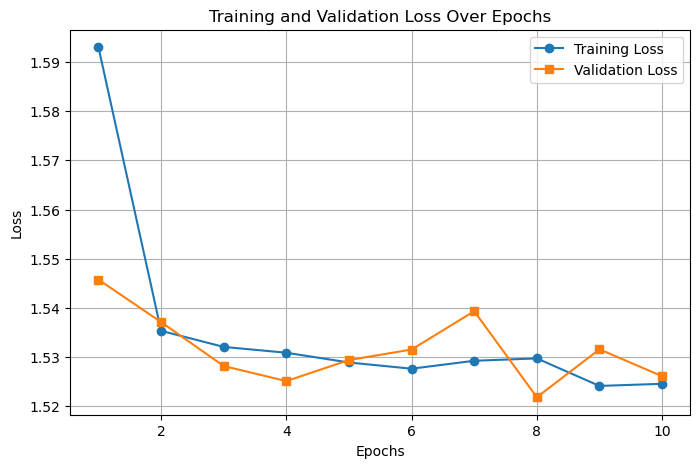

In [14]:
# Plot training and validation loss
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs + 1), train_loss_history, label='Training Loss', marker='o')
plt.plot(range(1, epochs + 1), val_loss_history, label='Validation Loss', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Part 2: Training with BindsNet

In [1]:
from ale_py import ALEInterface, roms

ale = ALEInterface()

A.L.E: Arcade Learning Environment (version 0.10.2+c9d4b19)
[Powered by Stella]


In [ ]:
import gymnasium as gym
print(gym.envs.registry.keys())  # List all registered environments

In [2]:
from bindsnet.encoding import bernoulli
from bindsnet.environment import GymEnvironment
from bindsnet.learning import MSTDP
from bindsnet.network import Network
from bindsnet.network.nodes import Input, LIFNodes
from bindsnet.network.topology import Connection
from bindsnet.pipeline import EnvironmentPipeline
from bindsnet.pipeline.action import select_softmax
import gymnasium as gym
# Build network.
network = Network(dt=1.0)

# Layers of neurons.
# first experiment with n = 100
# second experiment with n = 256
inpt = Input(n=80 * 80, shape=[1, 1, 1, 80, 80], traces=True)
middle = LIFNodes(n=256, traces=True)
out = LIFNodes(n=6, refrac=0, traces=True)

# Connections between layers.
# First experiment with nu = 1e-1, and norm = 0.5 * middle.n
inpt_middle = Connection(source=inpt, target=middle, wmin=0, wmax=1e-1)
middle_out = Connection(
    source=middle,
    target=out,
    wmin=0,
    wmax=1,
    update_rule=MSTDP,
    nu=1e-2,
    norm=0.3 * middle.n,
)

# Add all layers and connections to the network.
network.add_layer(inpt, name="Input Layer")
network.add_layer(middle, name="Hidden Layer")
network.add_layer(out, name="Output Layer")
network.add_connection(inpt_middle, source="Input Layer", target="Hidden Layer")
network.add_connection(middle_out, source="Hidden Layer", target="Output Layer")

# Load the Breakout environment.
environment = gym.make("SpaceInvaders-v0", render_mode="human")
environment.reset()

# Build pipeline from specified components.
environment_pipeline = EnvironmentPipeline(
    network,
    environment,
    encoding=bernoulli,
    action_function=select_softmax,
    output="Output Layer",
    time=100,
    history_length=1,
    delta=1,
    plot_interval=1,
    render_interval=1,
)
reward_list = []

def run_pipeline(pipeline, episode_count):
    for i in range(episode_count):
        total_reward = 0
        pipeline.reset_state_variables()
        is_done = False
        while not is_done:
            result = pipeline.env_step()
            #print(f"env_step() returned: {result}")
            obs, reward, terminated, truncated, info = result  
            is_done = terminated or truncated  

            #reward = result[1]
            total_reward += reward
        reward_list.append(total_reward)
            #is_done = result[2]
        print(f"Episode {i} total reward:{total_reward}")


# enable MSTDP
environment_pipeline.network.learning = True

print("Training: ")
run_pipeline(environment_pipeline, episode_count=100)
reward_list_training = reward_list
reward_list = []
# stop MSTDP
environment_pipeline.network.learning = False

print("Testing: ")
run_pipeline(environment_pipeline, episode_count=100)
reward_list_test = reward_list

A.L.E: Arcade Learning Environment (version 0.10.2+c9d4b19)
[Powered by Stella]


Training: 
Episode 0 total reward:105.0
Episode 1 total reward:155.0
Episode 2 total reward:155.0
Episode 3 total reward:180.0
Episode 4 total reward:225.0
Episode 5 total reward:155.0
Episode 6 total reward:145.0
Episode 7 total reward:210.0
Episode 8 total reward:110.0
Episode 9 total reward:125.0
Episode 10 total reward:100.0
Episode 11 total reward:285.0
Episode 12 total reward:30.0
Episode 13 total reward:220.0
Episode 14 total reward:155.0
Episode 15 total reward:125.0
Episode 16 total reward:65.0
Episode 17 total reward:55.0
Episode 18 total reward:155.0
Episode 19 total reward:125.0
Episode 20 total reward:160.0
Episode 21 total reward:180.0
Episode 22 total reward:120.0
Episode 23 total reward:180.0
Episode 24 total reward:230.0
Episode 25 total reward:120.0
Episode 26 total reward:210.0
Episode 27 total reward:210.0
Episode 28 total reward:80.0
Episode 29 total reward:80.0
Episode 30 total reward:215.0
Episode 31 total reward:120.0
Episode 32 total reward:135.0
Episode 33 tot

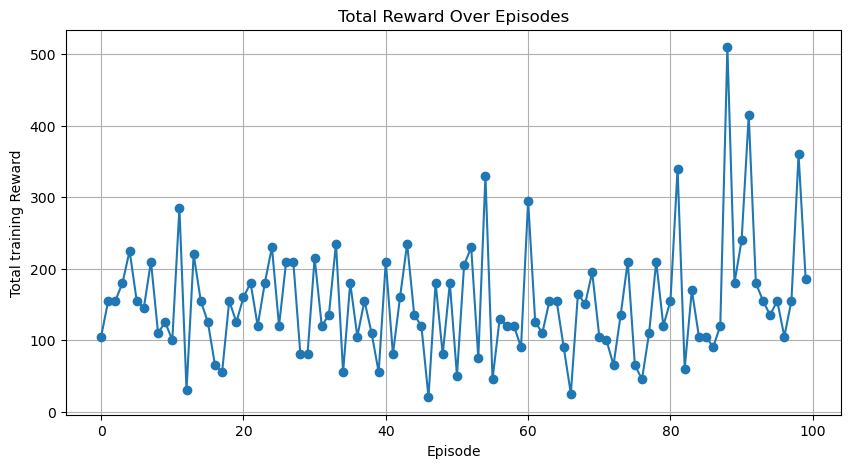

In [3]:
import matplotlib.pyplot as plt
# Plot rewards over episodes
plt.figure(figsize=(10, 5))
plt.plot(reward_list_training, marker='o', linestyle='-')
plt.xlabel("Episode")
plt.ylabel("Total training Reward")
plt.title("Total Reward Over Episodes")
plt.grid(True)
plt.show()

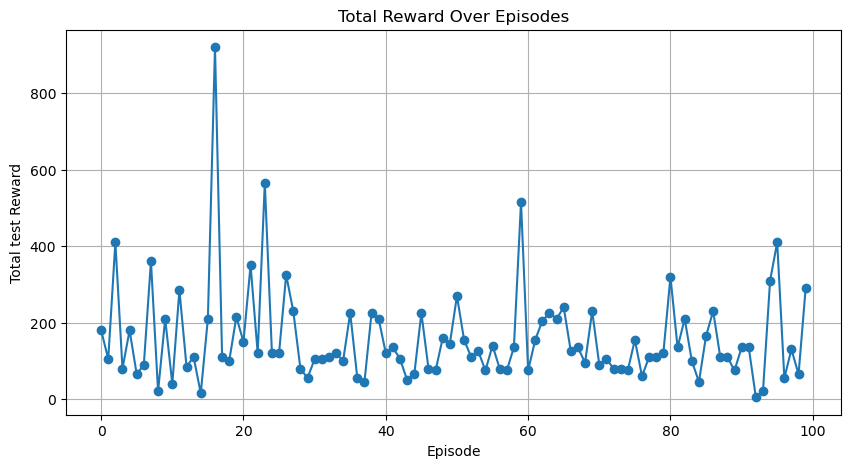

In [4]:
plt.figure(figsize=(10, 5))
plt.plot(reward_list_test, marker='o', linestyle='-')
plt.xlabel("Episode")
plt.ylabel("Total test Reward")
plt.title("Total Reward Over Episodes")
plt.grid(True)
plt.show()